In [1]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import time

In [2]:
# class for ROI (region of interest) proposal
class ROI:
    def __init__(self, max_dimension=800, roi_threshold_low=100, roi_threshold_high=500, canny_low=100, canny_high=200) -> None:
        self.rois = []
        self.max_dimension = max_dimension
        self.roi_threshold_low = roi_threshold_low
        self.roi_threshold_high = roi_threshold_high
        self.canny_low = canny_low
        self.canny_high = canny_high
    
    def get_rois(self, img):
        max_dimension = max(img.shape)
        scale = self.max_dimension / max_dimension
        my_img = cv2.resize(img, None, fx=scale, fy=scale)
        edges = cv2.Canny(my_img, self.canny_low, self.canny_high)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        rois = []
        for contour in contours:
            # filter contours by area
            area = cv2.contourArea(contour)
            if area > self.roi_threshold_low and area < self.roi_threshold_high:
                x, y, w, h = cv2.boundingRect(contour)
                rois.append([x, y, w, h])
        return rois

In [3]:
class ImageTools():
    def __init__(self, image_path):
        self.image_path = image_path
    
    def read_calibration(self, calib_path):
        with open(os.path.join(self.image_path, calib_path), 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P
    
    def read_groundtruth_path(self, gt_path):
        path = []
        with open(os.path.join(self.image_path, gt_path), 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                path.append(T)
        return np.array(path)

    def read_images(self, image_path):
        images = []
        for filename in sorted(os.listdir(os.path.join(self.image_path, image_path))):
            img = cv2.imread(os.path.join(os.path.join(self.image_path, image_path), filename))
            images.append(img)
        return images
    
    def read_all(self):
        K, P = self.read_calibration('calib.txt')
        path = self.read_groundtruth_path('poses.txt')
        images = self.read_images('image_l')
        return K, P, path, images

In [4]:
class PlottingTools():
    def plot_trajectory(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        fig = plt.figure()
        # set limit on x axis
        plt.xlim(-10, 10)
        plt.plot(truth_path[:, 0, 3], truth_path[:, 2, 3], label='Ground Truth')
        plt.plot(estimated_path[:, 0, 3], estimated_path[:, 2, 3], label='Estimated')
        plt.legend()
        plt.show()

    def plot_error(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        error = np.linalg.norm(truth_path[:, :3, 3] - estimated_path[:, :3, 3], axis=1)
        plt.plot(error)
        plt.show()

In [5]:
class VisualOdometryWithROI():
    def __init__(self, K, P, groundtruth_poses, images, feature_method="orb", match_threshold=0.5):
        self.K = K
        self.P = P
        self.groundtruth_poses = groundtruth_poses
        self.images = images
        self.feature_method = feature_method
        if feature_method == "orb":
            self.feature_detector = cv2.ORB_create(3000)
            FLANN_INDEX_LSH = 6
            index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
        elif feature_method == "sift":
            self.feature_detector = cv2.SIFT_create()
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
        else:
            raise ValueError("Feature method not supported")
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

        # ROI related
        self.roi_object = ROI(max_dimension=1200,
                              roi_threshold_low=100,
                              roi_threshold_high=600)
        self.last_kp = None
        self.last_des = None
        self.match_threshold = match_threshold
        self.last_roi = None
    
    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        return T
    
    def get_matches(self, i):
        kp1, des1 = self.feature_detector.detectAndCompute(self.images[i-1], None)
        kp2, des2 = self.feature_detector.detectAndCompute(self.images[i], None)
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(des1, des2, k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")

        good_matches = []
        for m, n in matches:
            if m.distance < self.match_threshold * n.distance:
                good_matches.append(m)
        
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

        return q1, q2
    
    def get_matches_roi(self, i, roi):
        kp1 = self.last_kp
        des1 = self.last_des
        kp2, des2 = self.get_kp_des(i, roi)
        self.last_kp = kp2
        self.last_des = des2
        if self.feature_method == "orb":
            matches = self.flann.knnMatch(np.array(des1), np.array(des2), k=2)
        elif self.feature_method == "sift":
            matches = self.flann.knnMatch(np.array(des1).astype(np.float32), np.array(des2).astype(np.float32), k=2)
        else:
            raise ValueError("Feature method not supported")
        good_matches = []
        if len(matches) > 0:
            for m, n in matches:
                if m.distance < self.match_threshold * n.distance:
                    good_matches.append(m)
        q1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
        q2 = np.array([kp2[m.trainIdx].pt for m in good_matches])
        return q1, q2, kp2
    
    def get_kp_des(self, i, rois):
        kp_list = []
        des_list = []
        for roi in rois:
            roi_img = self.images[i][roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
            kp, des = self.feature_detector.detectAndCompute(roi_img, None)
            for k in kp:
                k.pt = (k.pt[0] + roi[0], k.pt[1] + roi[1])
            if len(kp) == 0:
                continue
            kp_list.extend(kp)
            des_list.extend(des)
        return kp_list, des_list
    
    def get_pose(self, q1, q2):
        # Essential, mask = cv2.findEssentialMat(q1, q2, self.K, cv2.RANSAC, 0.999, 1.0)
        Essential, _ = cv2.findEssentialMat(q1, q2, self.K)
        R, t = self.decompose(Essential, q1, q2)
        return self._form_transf(R, t)
    
    def decompose(self, Essential, q1, q2):
        R1, R2, t = cv2.decomposeEssentialMat(Essential)
        T1 = self._form_transf(R1,np.ndarray.flatten(t))
        T2 = self._form_transf(R2,np.ndarray.flatten(t))
        T3 = self._form_transf(R1,np.ndarray.flatten(-t))
        T4 = self._form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        K = np.concatenate(( self.K, np.zeros((3,1)) ), axis = 1)
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]
        np.set_printoptions(suppress=True)
        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  
            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1) /
                                     (np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1) + 1e-8))
            positives.append(total_sum + relative_scale)
        max = np.argmax(positives)
        if (max == 2):
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            return R2, np.ndarray.flatten(t)

    def get_trajectory(self):
        truth_path = []
        estimated_path = []
        # time_for_roi = []
        # time_for_feature = []
        for i, true_pose in enumerate(tqdm(self.groundtruth_poses, unit="frame")):
            if i == 0:
                current_pose = true_pose
                roi = self.roi_object.get_rois(self.images[i])
                self.last_kp, self.last_des = self.get_kp_des(i, roi)
            else:
                # time1 = time.time()
                roi = self.roi_object.get_rois(self.images[i])
                q1, q2, new_keypoints = self.get_matches_roi(i, roi)
                self.plot_roi_and_keypoints(i, roi, new_keypoints)
                # time_for_roi.append(time.time() - time1)
                # time2 = time.time()
                # q11, q22 = self.get_matches(i)
                # time_for_feature.append(time.time() - time2)
                estimated_pose_from_feature = self.get_pose(q1, q2)
                estimated_pose = estimated_pose_from_feature
                current_pose = np.matmul(current_pose, np.linalg.inv(estimated_pose))
            truth_path.append(true_pose)
            estimated_path.append(current_pose)
        return truth_path, estimated_path #, time_for_roi, time_for_feature
    
    def plot_roi_and_keypoints(self, i, roi, keypoints):
        img = self.images[i].copy()
        for r in roi:
            cv2.rectangle(img, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (0, 255, 0), 2)
        img = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=0)
        # use a cv2 window to display images
        cv2.imshow('ROI & keypoints', img)
        cv2.waitKey(200)

100%|██████████| 51/51 [00:14<00:00,  3.56frame/s]


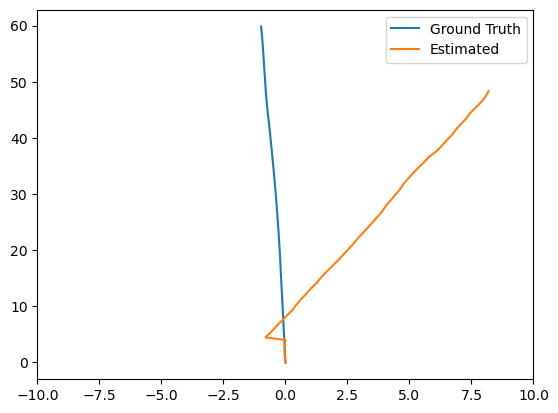

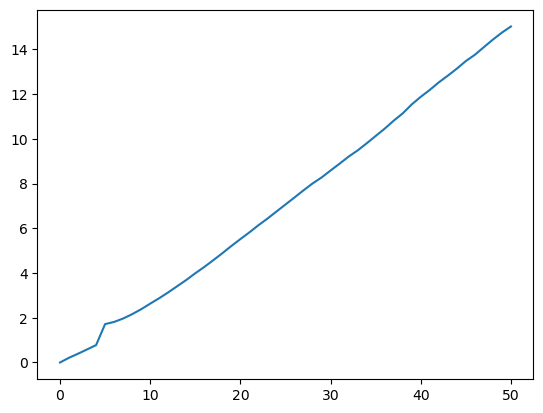

: 

In [7]:
data_path = "KITTI_sequence_1"
image_tools = ImageTools(data_path)
K, P, path, images = image_tools.read_all()
vo = VisualOdometryWithROI(K, P, path, images, feature_method="sift")
truth_path, estimated_path = vo.get_trajectory()
plot_tools = PlottingTools()
plot_tools.plot_trajectory(truth_path, estimated_path)
plot_tools.plot_error(truth_path, estimated_path)

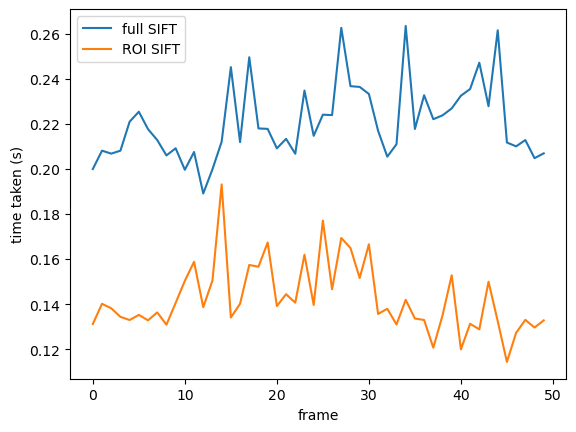

In [17]:
# plot time_taken_for_feature and time_taken_for_object
plt.plot(time_for_feature, label='full SIFT')
plt.plot(time_for_roi, label='ROI SIFT')
# label axis
plt.xlabel('frame')
plt.ylabel('time taken (s)')
plt.legend()
plt.show()